In [2]:
import torch
from torch import nn
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor

In [96]:
vgg_model = vgg16()

In [97]:
to_tensor_transform = ToTensor()

In [98]:
# 224x224 input size
style_image = Image.open('./data/style_transfer/starry_night.jpg')
content_image = Image.open('./data/style_transfer/yi_long_ma.jpg')

style_image = style_image.resize((256, 256))
content_image = content_image.resize((256, 256))

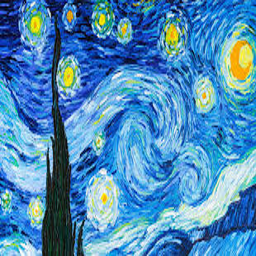

In [99]:
style_image

In [100]:
style_image = to_tensor_transform(style_image)
content_image = to_tensor_transform(content_image)

In [101]:
vgg_model.features[:30]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

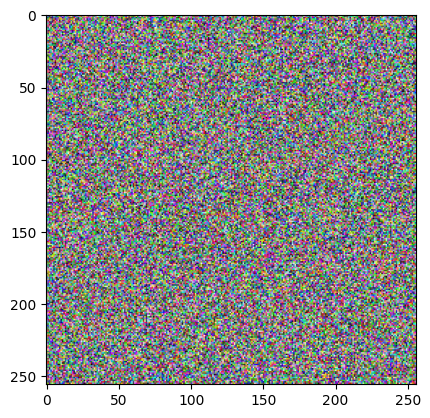

In [227]:
# content replication
noise = torch.rand((3, 256, 256))
noise.requires_grad = True
plt.imshow(noise.permute(1,2,0).detach().numpy())

In [161]:
# content? 
content_feature_output = vgg_model.features[:11](content_image.to("cuda"))

In [162]:
averaged_fortnite = content_feature_output.mean(dim=0).detach()

In [69]:
content_feature_output[5].min()

tensor(-0.5594, grad_fn=<MinBackward1>)

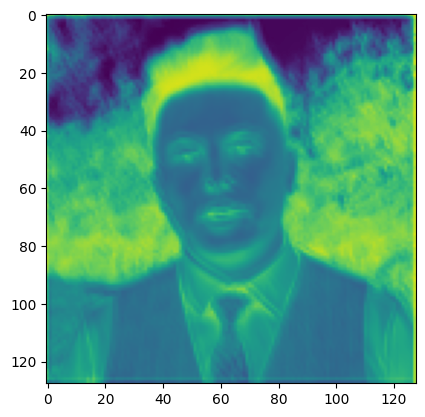

In [67]:
plt.imshow(content_feature_output[5].detach().numpy())

In [12]:
0noise_feature_output.shape, averaged_fortnite.shape

NameError: name 'noise_feature_output' is not defined

In [216]:
for i in range(25):
    vgg_model.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:11](noise).mean(dim=0)
    content_loss = ((noise_feature_output - averaged_fortnite)**2).sum()
    content_loss.backward()
    with torch.no_grad():
        print(content_loss, torch.norm(noise.grad), "                ", end="\r")
        noise = noise - noise.grad * 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


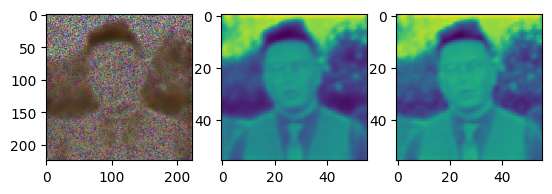

In [217]:
fig, axs = plt.subplots(1, 3)
axs[0].imshow(noise.detach().permute(1,2,0).numpy())
axs[1].imshow(noise_feature_output.detach().numpy())
axs[2].imshow(averaged_fortnite.detach().numpy())

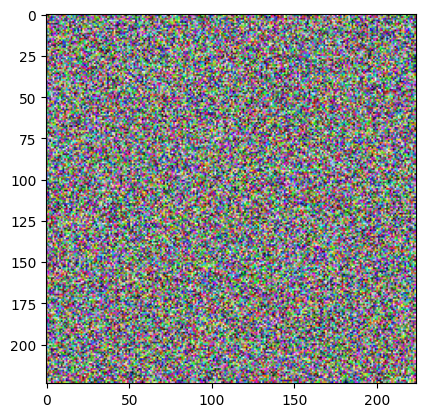

In [157]:
plt.imshow(noise.detach().permute(1,2,0).numpy())

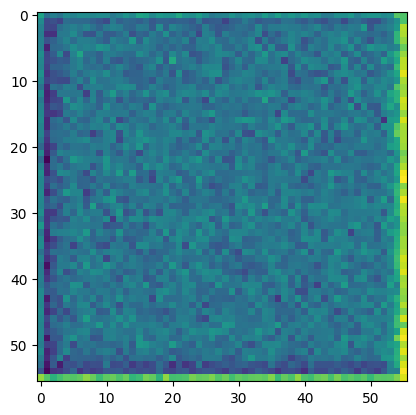

In [159]:
plt.imshow(noise_feature_output.detach().numpy())

In [ ]:
fig, axs = plt.subplots(16, 16, figsize=(20,20))
for i in range(16):
    for j in range(16):
        axs[i][j].imshow(content_feature_output[i*16+j].detach().numpy())

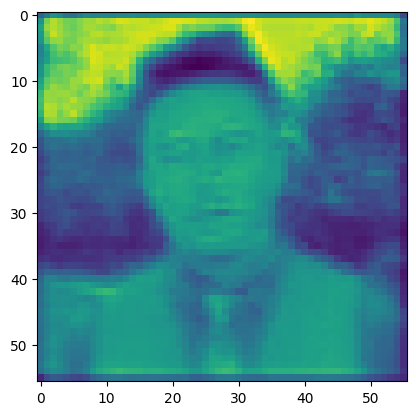

In [227]:
plt.imshow(averaged_fortnite.detach().numpy())

In [228]:
# style replication
style_feature_output = vgg_model.features[:11](style_image.to('cuda'))

In [229]:
style_feature_output = style_feature_output.view(128, -1)

In [42]:
torch.norm(style_feature_output)

tensor(59.4029, grad_fn=<LinalgVectorNormBackward0>)

In [43]:
style_feature_output /= torch.norm(style_feature_output)

In [230]:
gram_matrix = (style_feature_output @ style_feature_output.T).detach()

In [231]:
gram_matrix.max()

tensor(387.7706, device='cuda:0')

In [245]:
lbfgs = torch.optim.LBFGS([noise], lr=1.0)

In [239]:
#to cuda
vgg_model = vgg_model.to('cpu')
noise = noise.to('cpu')
gram_matrix = gram_matrix.to("cpu")

In [234]:
noise_gram_matrix = None

In [246]:
noise = noise.detach()

In [247]:
noise.requires_grad = True

In [248]:
def closure():
    lbfgs.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:11](noise).view(128, -1)

    noise_gram_matrix = noise_feature_output @ noise_feature_output.T

    style_loss = ((gram_matrix - noise_gram_matrix)**2).sum()
    style_loss.backward()

    return style_loss

In [249]:
while True:
    loss = lbfgs.step(closure)
    print(loss, "                                    ", end="\r")

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


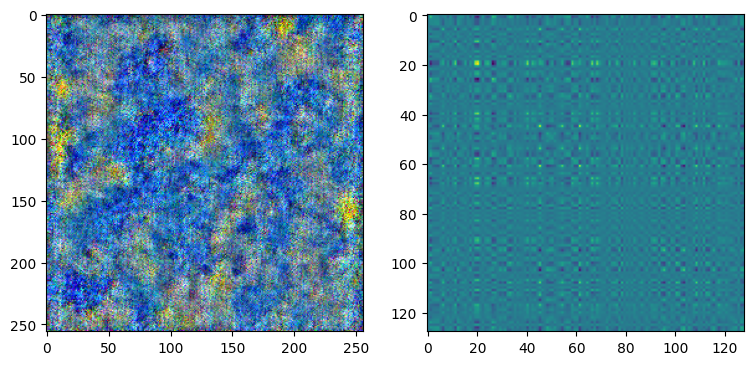

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs[0].imshow(noise.cpu().detach().permute(1,2,0).numpy())
# axs[1].imshow(noise_gram_matrix.detach().numpy())
axs[1].imshow(gram_matrix.cpu().detach().numpy())

In [224]:
lbfgs = torch.optim.LBFGS([noise], lr=1.0)

In [183]:
slider = 1.0

In [167]:
averaged_fortnite = averaged_fortnite.to('cuda')

In [220]:
# putting it together (style_loss + content_loss)

def closure():
    vgg_model.zero_grad()
    noise.requires_grad = True
    noise_feature_output = vgg_model.features[:11](noise).view(128, -1)
    # noise_feature_style = vgg_model.features[:11](noise)
    #flattened_noise_style = noise_feature_output.view(128, -1)

    #flattened_noise_feature /= torch.norm(flattened_noise_feature).detach()
    
    noise_gram_matrix = noise_feature_output @ noise_feature_output.T

    style_loss = ((gram_matrix - noise_gram_matrix)**2).sum()
    #content_loss = ((noise_feature_output - averaged_fortnite)**2).sum()

    #total_loss = style_loss 

    style_loss.backward()

    return style_loss



In [199]:
adam = torch.optim.Adam([noise], lr=.005)

In [221]:
noise = torch.rand((3, 256, 256))
noise.requires_grad = True
noise = noise.to('cuda').detach()

In [222]:
noise.requires_grad = True

In [ ]:
# adam optimization
index = 0
while True:
    print(index, closure(), "                                           ", end="\r")
    adam.step()
    index += 1

In [225]:
# lbfgs optimization
while True:
    loss = lbfgs.step(closure)
    print(loss, "                                    ", end="\r")

KeyboardInterrupt: 

d:\PythonLang\Py3-11-2\Lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


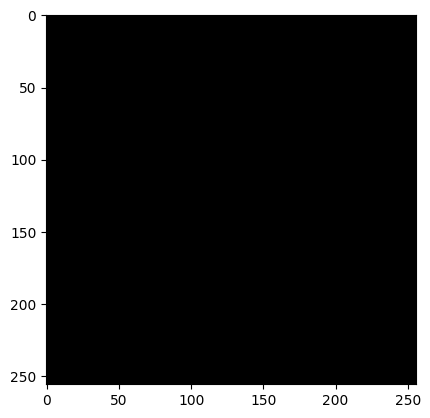

In [226]:
plt.imshow(noise.cpu().detach().permute(1,2,0).numpy())
